**Challenge:** Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

**Data source:** https://www.kaggle.com/uciml/pima-indians-diabetes-database#diabetes.csv. This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. All patients are females at least 21 years old of Pima Indian heritage.

# Setting up environment and uploading data

In [57]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
diabetes_df = pd.read_csv("...diabetes.csv")

In [60]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [61]:
diabetes_df.shape

(768, 9)

In [62]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [63]:
diabetes_df.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


# Exploring and handling feature distributions

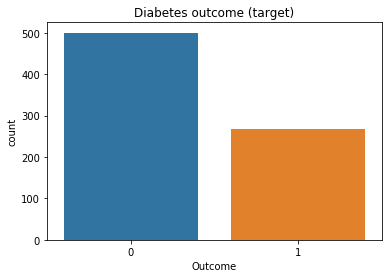

In [64]:
# visualizing distribution of target
sns.countplot(x='Outcome', data=diabetes_df)
plt.title('Diabetes outcome (target)');

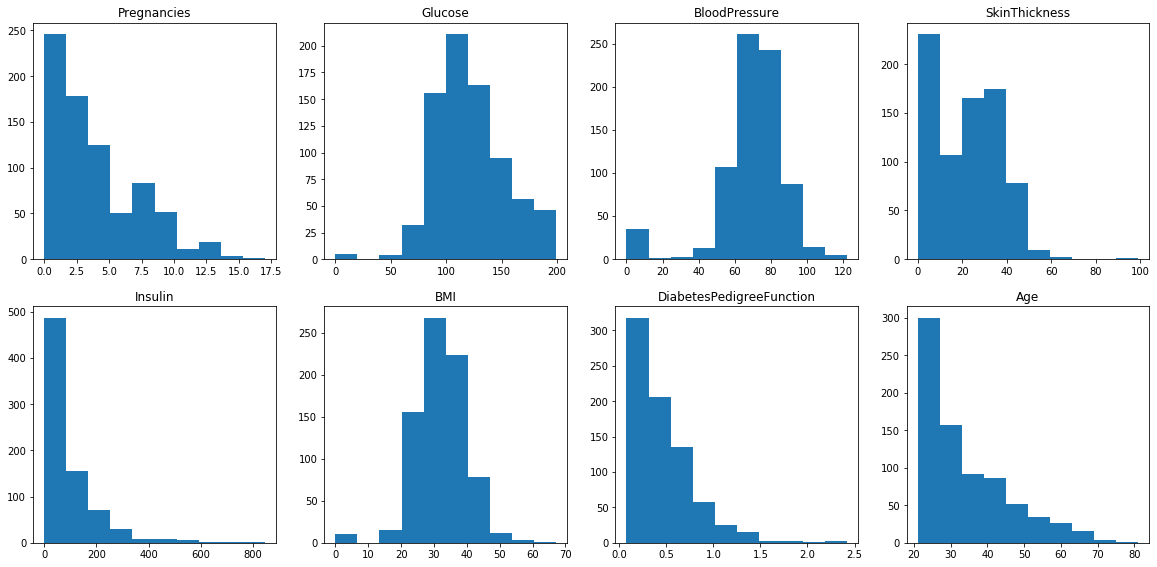

In [65]:
# visualizing distribution of features

x=1
plt.figure(figsize=(20,20))
for col in diabetes_df.drop(['Outcome'], axis=1).columns:
    plt.subplot(4,4,x)
    plt.hist(diabetes_df[col])
    plt.title(col)
    x=x+1

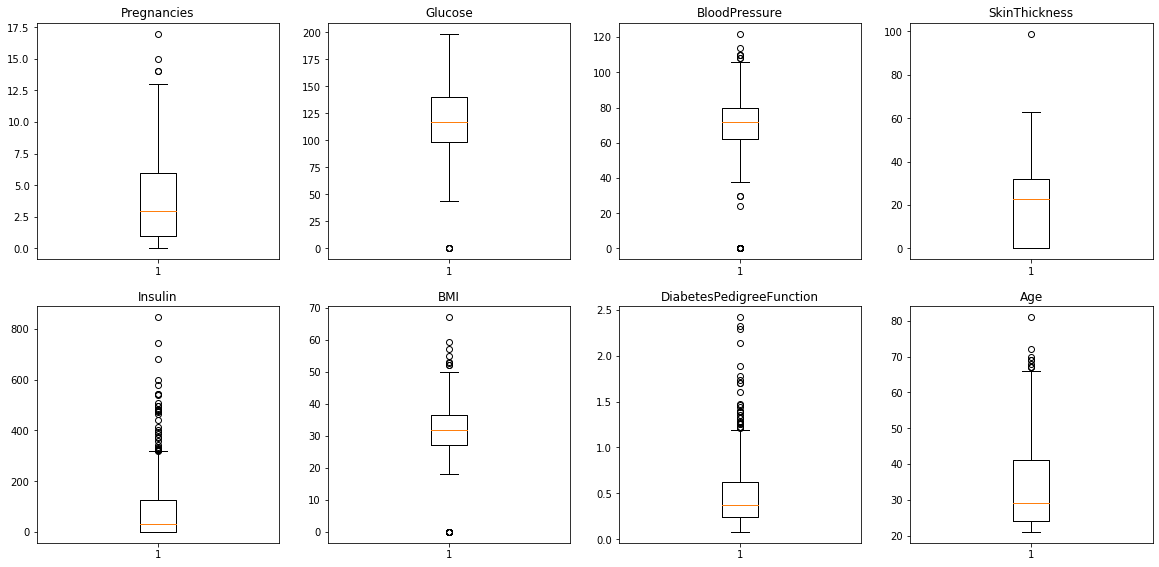

In [66]:
x=1
plt.figure(figsize=(20,20))
for col in diabetes_df.drop(['Outcome'], axis=1).columns:
    plt.subplot(4,4,x)
    plt.boxplot(diabetes_df[col])
    plt.title(col)
    x=x+1

In [67]:
# initial normal tests
print('Pregnancies: {}'.format(stats.normaltest(diabetes_df.Pregnancies)))
print('Glucose: {}'.format(stats.normaltest(diabetes_df.Glucose)))
print('BP: {}'.format(stats.normaltest(diabetes_df.BloodPressure)))
print('SkinThickness: {}'.format(stats.normaltest(diabetes_df.SkinThickness)))
print('Insulin: {}'.format(stats.normaltest(diabetes_df.Insulin)))
print('BMI: {}'.format(stats.normaltest(diabetes_df.BMI)))
print('DPF: {}'.format(stats.normaltest(diabetes_df.DiabetesPedigreeFunction)))
print('Age: {}'.format(stats.normaltest(diabetes_df.Age)))
print('Outcome: {}'.format(stats.normaltest(diabetes_df.Outcome)))

Pregnancies: NormaltestResult(statistic=80.16379459199477, pvalue=3.9142916387836715e-18)
Glucose: NormaltestResult(statistic=12.385056622689767, pvalue=0.0020446506991363502)
BP: NormaltestResult(statistic=305.8868872073318, pvalue=3.780127075543807e-67)
SkinThickness: NormaltestResult(statistic=17.344870537341908, pvalue=0.00017124157678801767)
Insulin: NormaltestResult(statistic=387.57777337173394, pvalue=6.895342740914799e-85)
BMI: NormaltestResult(statistic=86.14248428578559, pvalue=1.9696869549260572e-19)
DPF: NormaltestResult(statistic=321.83907808058314, pvalue=1.2987697487612696e-70)
Age: NormaltestResult(statistic=119.87763596211636, pvalue=9.308980038236578e-27)
Outcome: NormaltestResult(statistic=4556.9871951844825, pvalue=0.0)


I'll handle outliers where Glucose, BloodPressure, or BMI is 0.

In [68]:
# checking if these instances occur in the same patients
diabetes_df.loc[(diabetes_df['BloodPressure']==0) & (diabetes_df['Glucose']==0) & (diabetes_df['BMI']==0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [69]:
print('Number of columns with Glucose 0: {}'.format(len(diabetes_df.loc[(diabetes_df['Glucose']==0)])))
print('Number of columns with BP 0: {}'.format(len(diabetes_df.loc[(diabetes_df['BloodPressure']==0)])))
print('Number of columns with BMI 0: {}'.format(len(diabetes_df.loc[(diabetes_df['BMI']==0)])))

Number of columns with Glucose 0: 5
Number of columns with BP 0: 35
Number of columns with BMI 0: 11


In [70]:
# replacing 0s with null
diabetes_df['Glucose'].replace(0, np.nan, inplace=True)
diabetes_df['BloodPressure'].replace(0, np.nan, inplace=True)
diabetes_df['BMI'].replace(0, np.nan, inplace=True)

In [71]:
# dropping 51 rows
diabetes_df.dropna(inplace=True)

In [72]:
diabetes_df.shape

(724, 9)

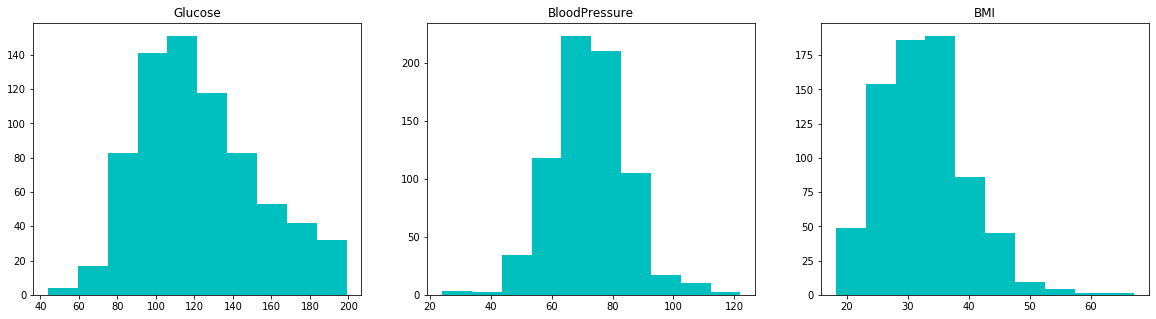

In [73]:
# visualizing updated distributions

x=1
plt.figure(figsize=(20,5))
for col in diabetes_df[['Glucose', 'BloodPressure', 'BMI']].columns:
    plt.subplot(1,3,x)
    plt.hist(diabetes_df[col], color='c')
    plt.title(col)
    x=x+1

Histograms for glucose, BP, and BMI appear close to normal. I'll try transforming the other 5 variables below. All skew right. 

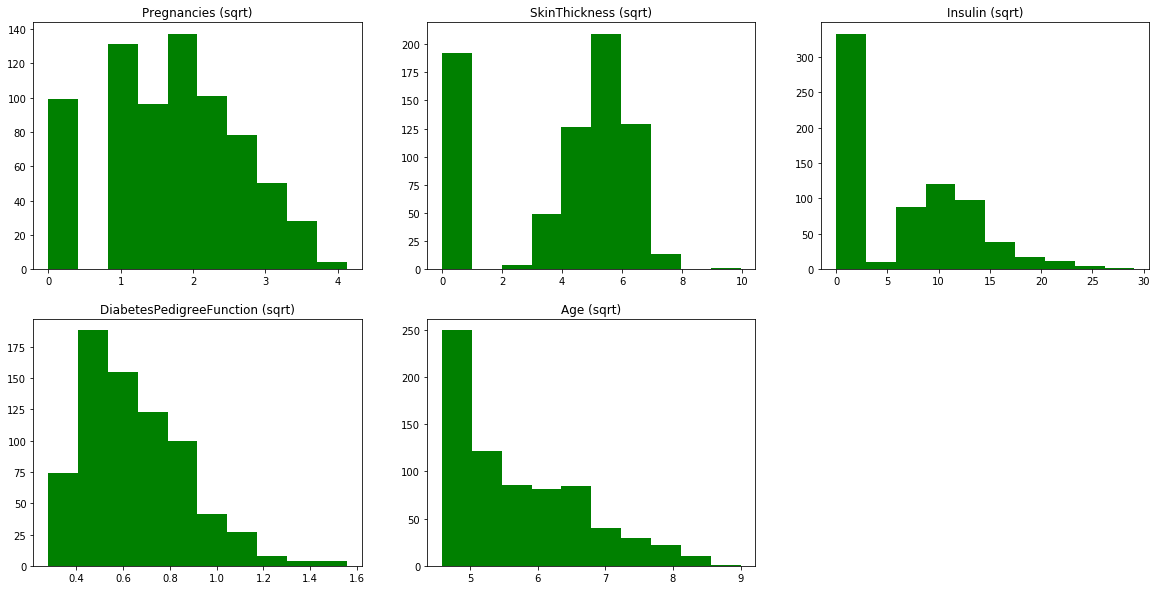

In [74]:
# visualizing sqrt transformations
x=1
plt.figure(figsize=(20,10))
for col in diabetes_df[['Pregnancies', 'SkinThickness', 'Insulin',
                        'DiabetesPedigreeFunction', 'Age']].columns:
    plt.subplot(2,3,x)
    plt.hist(np.sqrt(diabetes_df[col]), color = 'g')
    plt.title(col + ' (sqrt)')
    x=x+1

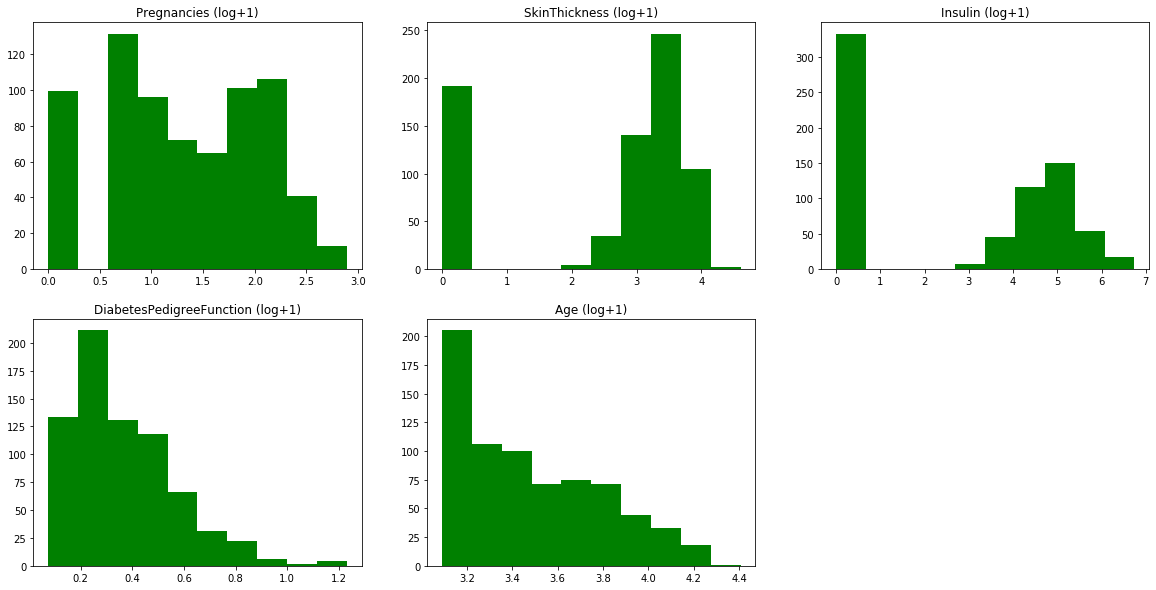

In [75]:
# visualizing log transformations
x=1
plt.figure(figsize=(20,10))
for col in diabetes_df[['Pregnancies', 'SkinThickness', 'Insulin',
                        'DiabetesPedigreeFunction', 'Age']].columns:
    plt.subplot(2,3,x)
    plt.hist(np.log(diabetes_df[col]+1), color = 'g')
    plt.title(col + ' (log+1)')
    x=x+1

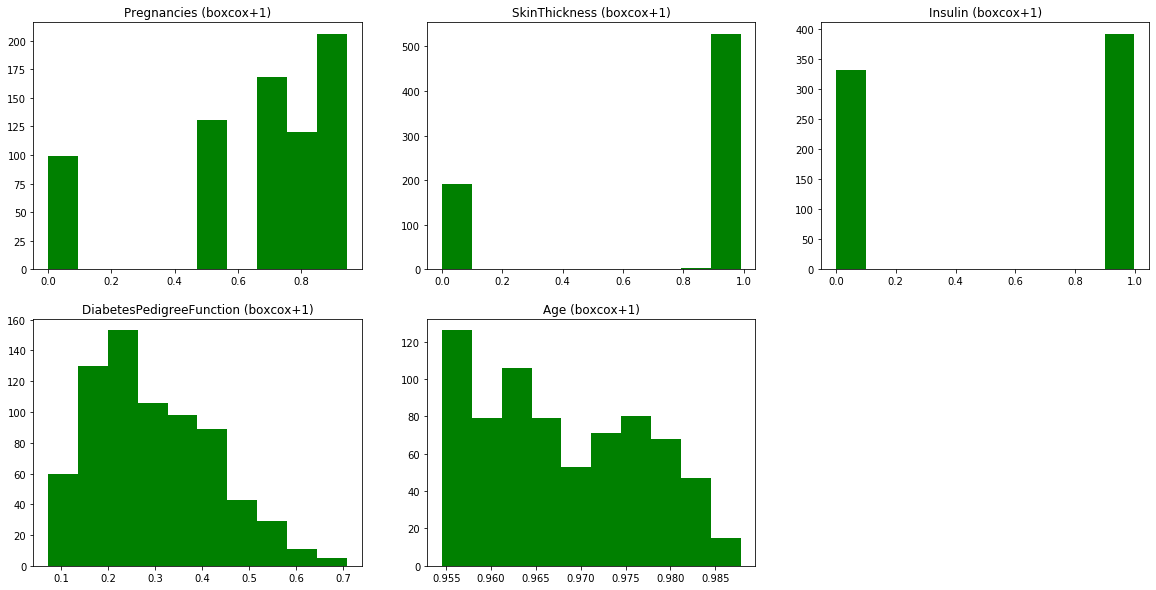

In [76]:
# visualizing reciprocal boxcox transformations

x=1
plt.figure(figsize=(20,10))
for col in diabetes_df[['Pregnancies', 'SkinThickness', 'Insulin',
                        'DiabetesPedigreeFunction', 'Age']].columns:
    plt.subplot(2,3,x)
    plt.hist(boxcox(diabetes_df[col]+1, lmbda=-1), color = 'g')
    plt.title(col + ' (boxcox+1)')
    x=x+1

In [77]:
# applying transformations that appear more normal
diabetes_df['Pregnancies'] = np.sqrt(diabetes_df['Pregnancies'])
diabetes_df['SkinThickness'] = np.sqrt(diabetes_df['SkinThickness'])
diabetes_df['Insulin'] = np.log(diabetes_df['Insulin']+1)
diabetes_df['DiabetesPedigreeFunction'] = boxcox(diabetes_df['DiabetesPedigreeFunction'], lmbda=-1)
diabetes_df['Age'] = boxcox(diabetes_df['Age'], lmbda=-1)

In [78]:
# post-transformation normal tests
print('Pregnancies: {}'.format(stats.normaltest(diabetes_df.Pregnancies)))
print('Glucose: {}'.format(stats.normaltest(diabetes_df.Glucose)))
print('BP: {}'.format(stats.normaltest(diabetes_df.BloodPressure)))
print('SkinThickness: {}'.format(stats.normaltest(diabetes_df.SkinThickness)))
print('Insulin: {}'.format(stats.normaltest(diabetes_df.Insulin)))
print('BMI: {}'.format(stats.normaltest(diabetes_df.BMI)))
print('DPF: {}'.format(stats.normaltest(diabetes_df.DiabetesPedigreeFunction)))
print('Age: {}'.format(stats.normaltest(diabetes_df.Age)))

Pregnancies: NormaltestResult(statistic=36.39208142870105, pvalue=1.2518719982125278e-08)
Glucose: NormaltestResult(statistic=33.91420748679928, pvalue=4.321389528064727e-08)
BP: NormaltestResult(statistic=16.04996423800435, pvalue=0.00032718587646603215)
SkinThickness: NormaltestResult(statistic=250.2953398475837, pvalue=4.457152863977028e-55)
Insulin: NormaltestResult(statistic=3159.0544119897218, pvalue=0.0)
BMI: NormaltestResult(statistic=51.90759102755313, pvalue=5.3506904152008145e-12)
DPF: NormaltestResult(statistic=195.3111649403654, pvalue=3.878996664462688e-43)
Age: NormaltestResult(statistic=507.93143566300347, pvalue=5.059296747016703e-111)


The features for this model are not normal, but transformations did improve them for modeling.

# Modeling

In [79]:
X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df.Outcome

# standardizing features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## MLP Classifier

In [80]:
# default has one layer with 100 neurons
mlp1 = MLPClassifier(hidden_layer_sizes=(100,))
mlp1.fit(X_std, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [81]:
mlp1.score(X_std, y)

0.8162983425414365

In [82]:
cross_val_score(mlp1, X_std, y, cv=5)

array([0.7862069 , 0.71034483, 0.75862069, 0.7862069 , 0.77777778])

### Parameter tuning

In [83]:
# two layers, 100 and 5
mlp2 = MLPClassifier(hidden_layer_sizes=(100, 5))
mlp2.fit(X_std, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [84]:
mlp2.score(X_std, y)

0.8328729281767956

In [85]:
cross_val_score(mlp2, X_std, y, cv=5)

array([0.74482759, 0.69655172, 0.73103448, 0.77241379, 0.79166667])

In [86]:
# two layers, 100 and 50
mlp3 = MLPClassifier(hidden_layer_sizes=(100, 50))
mlp3.fit(X_std, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [87]:
mlp3.score(X_std, y)

0.9185082872928176

In [88]:
cross_val_score(mlp3, X_std, y, cv=5)

array([0.76551724, 0.71724138, 0.75172414, 0.76551724, 0.77777778])

In [89]:
# three layers, 50, 5, and 5
mlp4 = MLPClassifier(hidden_layer_sizes=(50, 5, 5))
mlp4.fit(X_std, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [90]:
mlp4.score(X_std, y)

0.8466850828729282

In [91]:
cross_val_score(mlp4, X_std, y, cv=5)

array([0.75172414, 0.73793103, 0.74482759, 0.80689655, 0.79861111])

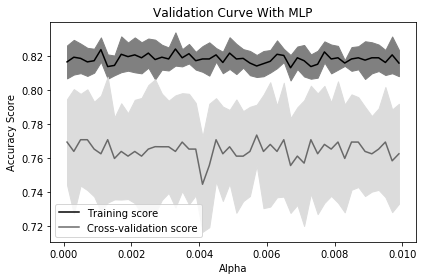

In [92]:
# plotting range of alpha
# Source code for plotting validation curves: 
# https://chrisalbon.com/machine_learning/model_evaluation/plot_the_validation_curve/

# Create range of values for parameter
param_range = np.arange(.0001, .01, .0002)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(MLPClassifier(), 
                                             X_std, 
                                             y, 
                                             param_name='alpha', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='accuracy', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With MLP")
plt.xlabel("Alpha")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

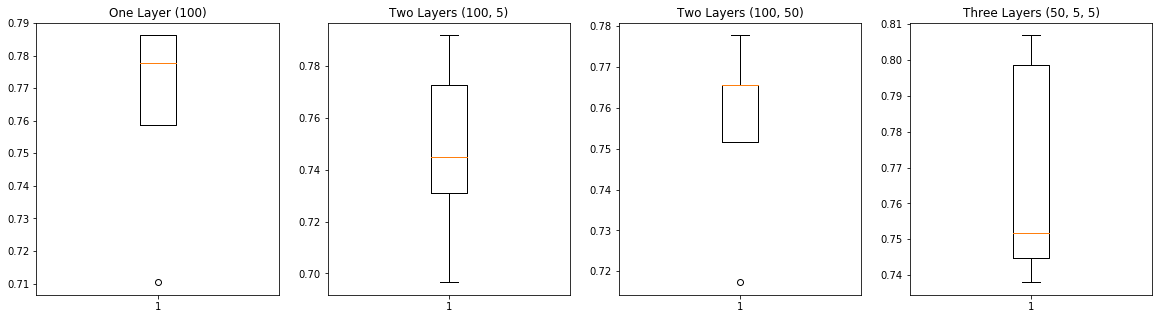

In [93]:
# plotting cv scores of 4 models above 

mlp1=[0.7862069 , 0.71034483, 0.75862069, 0.7862069 , 0.77777778]
mlp2=[0.74482759, 0.69655172, 0.73103448, 0.77241379, 0.79166667]
mlp3=[0.76551724, 0.71724138, 0.75172414, 0.76551724, 0.77777778]
mlp4=[0.75172414, 0.73793103, 0.74482759, 0.80689655, 0.79861111]

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.boxplot(mlp1)
plt.title('One Layer (100)')

plt.subplot(1,4,2)
plt.boxplot(mlp2)
plt.title('Two Layers (100, 5)')

plt.subplot(1,4,3)
plt.boxplot(mlp3)
plt.title('Two Layers (100, 50)')


plt.subplot(1,4,4)
plt.boxplot(mlp4)
plt.title('Three Layers (50, 5, 5)');

#### Observations:
The MLP models above performed similarly, between about 74% and 77% accuracy across 5 cv scores. All were also prone to overfitting. The model with three layers performed best. Alpha did not appear to impact accuracy or overfitting. 

## Random Forest

In [94]:
rfc1 = ensemble.RandomForestClassifier()
rfc1.fit(X_std, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [95]:
rfc1.score(X_std, y)

0.9792817679558011

In [96]:
cross_val_score(rfc1, X_std, y, cv=5)

array([0.76551724, 0.72413793, 0.72413793, 0.7862069 , 0.74305556])

### Parameter tuning

In [97]:
# review of default settings
rfc1.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [98]:
# testing criterion- entropy
rfc2 = ensemble.RandomForestClassifier(criterion='entropy')
rfc2.fit(X_std, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
rfc2.score(X_std, y)

0.9848066298342542

In [100]:
cross_val_score(rfc2, X_std, y, cv=5)

array([0.73103448, 0.76551724, 0.73103448, 0.80689655, 0.73611111])

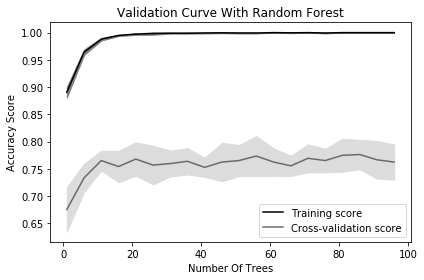

In [101]:
# plotting n_estimators

# Create range of values for parameter
param_range = np.arange(1, 100, 5)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(ensemble.RandomForestClassifier(), 
                                             X_std, 
                                             y, 
                                             param_name='n_estimators', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='accuracy', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

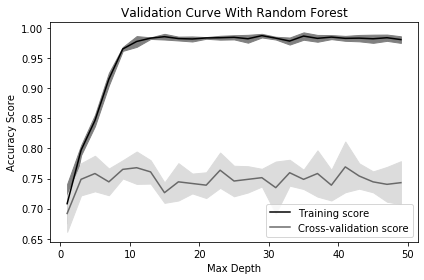

In [102]:
# plotting max_depth

# Create range of values for parameter
param_range = np.arange(1, 50, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(ensemble.RandomForestClassifier(), 
                                             X_std, 
                                             y, 
                                             param_name='max_depth', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='accuracy', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

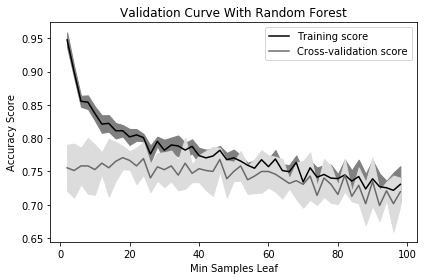

In [103]:
# plotting min_samples_leaf

# Create range of values for parameter
param_range = np.arange(2, 100, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(ensemble.RandomForestClassifier(), 
                                             X_std, 
                                             y, 
                                             param_name='min_samples_leaf', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='accuracy', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

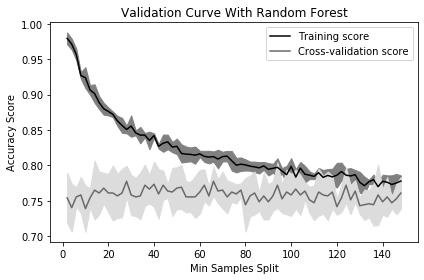

In [104]:
# plotting min_samples_split

# Create range of values for parameter
param_range = np.arange(2, 150, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(ensemble.RandomForestClassifier(), 
                                             X_std, 
                                             y, 
                                             param_name='min_samples_split', 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring='accuracy', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Min Samples Split")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [105]:
# testing new model based on validation curves
rfc3 = ensemble.RandomForestClassifier(n_estimators=10,
                                       max_depth=10, 
                                       min_samples_leaf=45,
                                       min_samples_split=100)
rfc3.fit(X_std, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=45, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [106]:
rfc3.score(X_std, y)

0.7776243093922652

In [107]:
cross_val_score(rfc3, X_std, y, cv=5)

array([0.74482759, 0.73103448, 0.73103448, 0.75172414, 0.76388889])

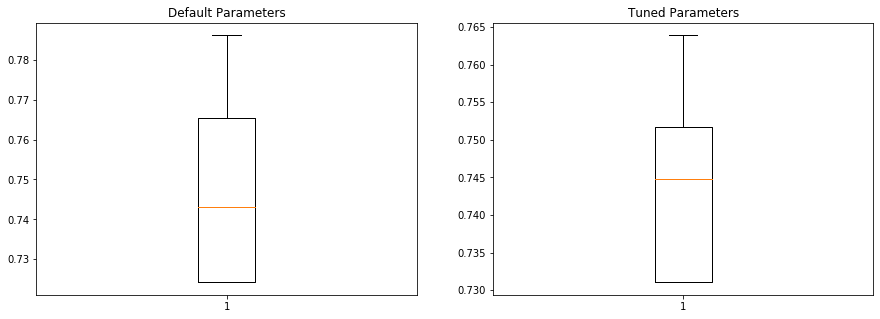

In [108]:
# plotting cv scores 

rfc_default=[0.76551724, 0.72413793, 0.72413793, 0.7862069 , 0.74305556]
rfc_tuned=[0.74482759, 0.73103448, 0.73103448, 0.75172414, 0.76388889]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.boxplot(rfc_default)
plt.title('Default Parameters')

plt.subplot(1,2,2)
plt.boxplot(rfc_tuned)
plt.title('Tuned Parameters');

#### Observations:
The Random Forest models above performed with about the same accuracy across 5 cv scores, 74%.  With tuning, I could correct for some overfitting.

# Conclusion
The MLP Classifier and Random Forest models performed similarly on this dataset and were able to predict diabetes with around 75% accuracy. While a neural network with three layers performed best at 77% accuracy, I don't think these results justify the additional complexity and computing power. Both models could be much improved with more features and occurrences. 